### AML Project Group 12: Linear Regression

### Import Libraries

In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load Train and Test Dataset

In [2]:
train = pd.read_csv("data/finaldf_train.csv",encoding="ISO-8859-1")
test = pd.read_csv("data/finaldf_test.csv",encoding="ISO-8859-1")

In [3]:
# Check the shape of train dataset
train.shape

(3389, 76)

In [4]:
# Check the shape of test dataset
test.shape

(1446, 76)

In [5]:
# Check the columns name
train.columns

Index(['Unnamed: 0', 'id', 'runtime', 'title', 'budget_adj', 'revenue_adj',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Thriller', 'War', 'Western',
       'original_language_en', 'original_language_es', 'original_language_fr',
       'original_language_hi', 'original_language_it', 'original_language_ja',
       'original_language_ko', 'original_language_ru', 'original_language_ta',
       'original_language_zh', 'original_language_others', 'Warner Bros.',
       'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Walt Disney Pictures', 'Touchstone Pictures',
       'Relativity Media', 'Metro-Goldwyn-Mayer (MGM)', 'Other Prod',
       'United States of America', 'United Kingdom', 'France', 'Germany',
       'Canada', 'India', 'Australia', 'Italy', 'Russia', 'J

In [6]:
len(train.columns)

76

### Drop unnecessary columns: Unnamed: 0, id, title

In [7]:
train.drop(["Unnamed: 0","id","title"], axis=1, inplace=True)
test.drop(["Unnamed: 0","id","title"], axis=1, inplace=True)

### Linear Regression with finalized data (without transformation and scaling)

In [8]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

# Build a linear regression using default parameters
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred_train = regr.predict(x_train)
y_pred_test = regr.predict(x_test)

print('Intercept:', regr.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': regr.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features:")
print(top10_features)

def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))
    
print("Average Revenue:", np.average(y_test))
print("Standard Deviation Revenue:", np.std(y_test))
    
print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))


print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))


Intercept: -200934879.68525204
Top 10 Features:
                                   Feature   Coefficient  Absolute Coefficient
12                                 History -7.433440e+07          7.433440e+07
58                              series_ind  7.097659e+07          7.097659e+07
4                                Animation  7.056870e+07          7.056870e+07
49                                   Italy -7.053756e+07          7.053756e+07
40               Metro-Goldwyn-Mayer (MGM) -6.613414e+07          6.613414e+07
60                            top_director  6.596931e+07          6.596931e+07
47                                   India -5.897853e+07          5.897853e+07
34  Twentieth Century Fox Film Corporation  5.370839e+07          5.370839e+07
33                      Paramount Pictures  4.980602e+07          4.980602e+07
25                    original_language_ja -4.823613e+07          4.823613e+07
Average Revenue: 148714997.19928363
Standard Deviation Revenue: 238963613.55572733


The coefficients are very high, the data need to be further investigated.

### Features Engineering

### Checking correlation matrix for all variables

In [9]:
matrix = train.corr()

<AxesSubplot:>

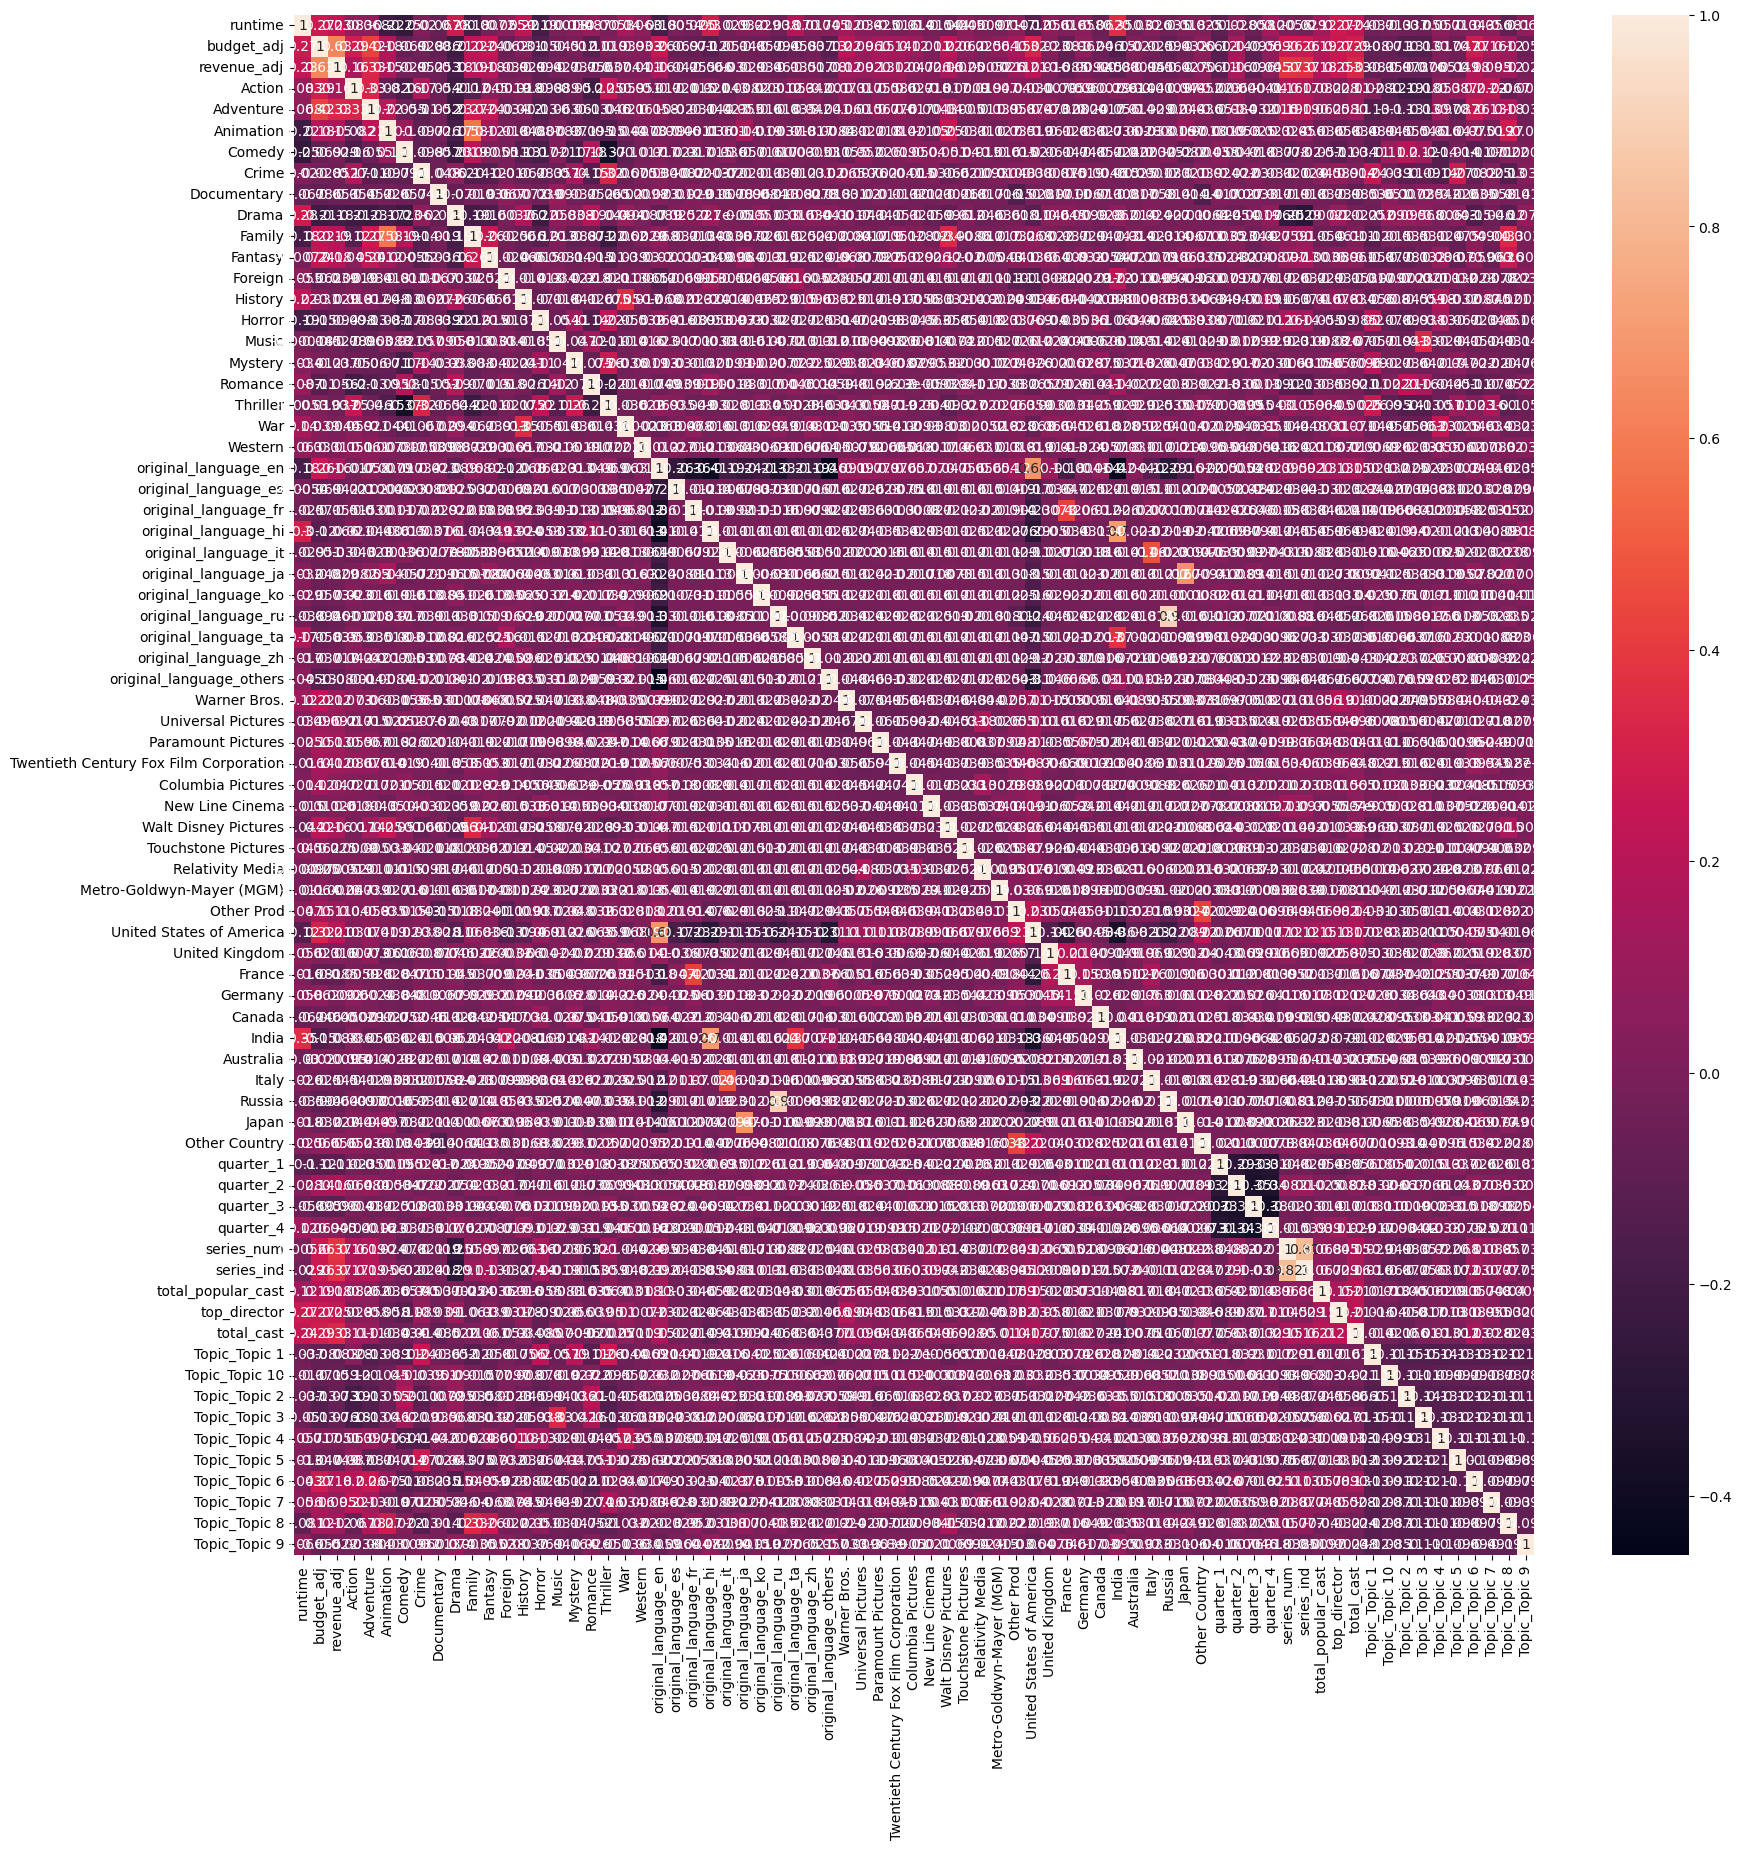

In [10]:
# Plot correlation matrix
plt.figure(figsize = (20,20))
sns.heatmap(matrix,annot = True)

From the correlation matrix color above, the high value (>0.6) is shown by lighter color.
- Zoom in the first 20 variables.
- Zoom in to the production country against language variables.
- Zoom in to series_num and series_ind

<AxesSubplot:>

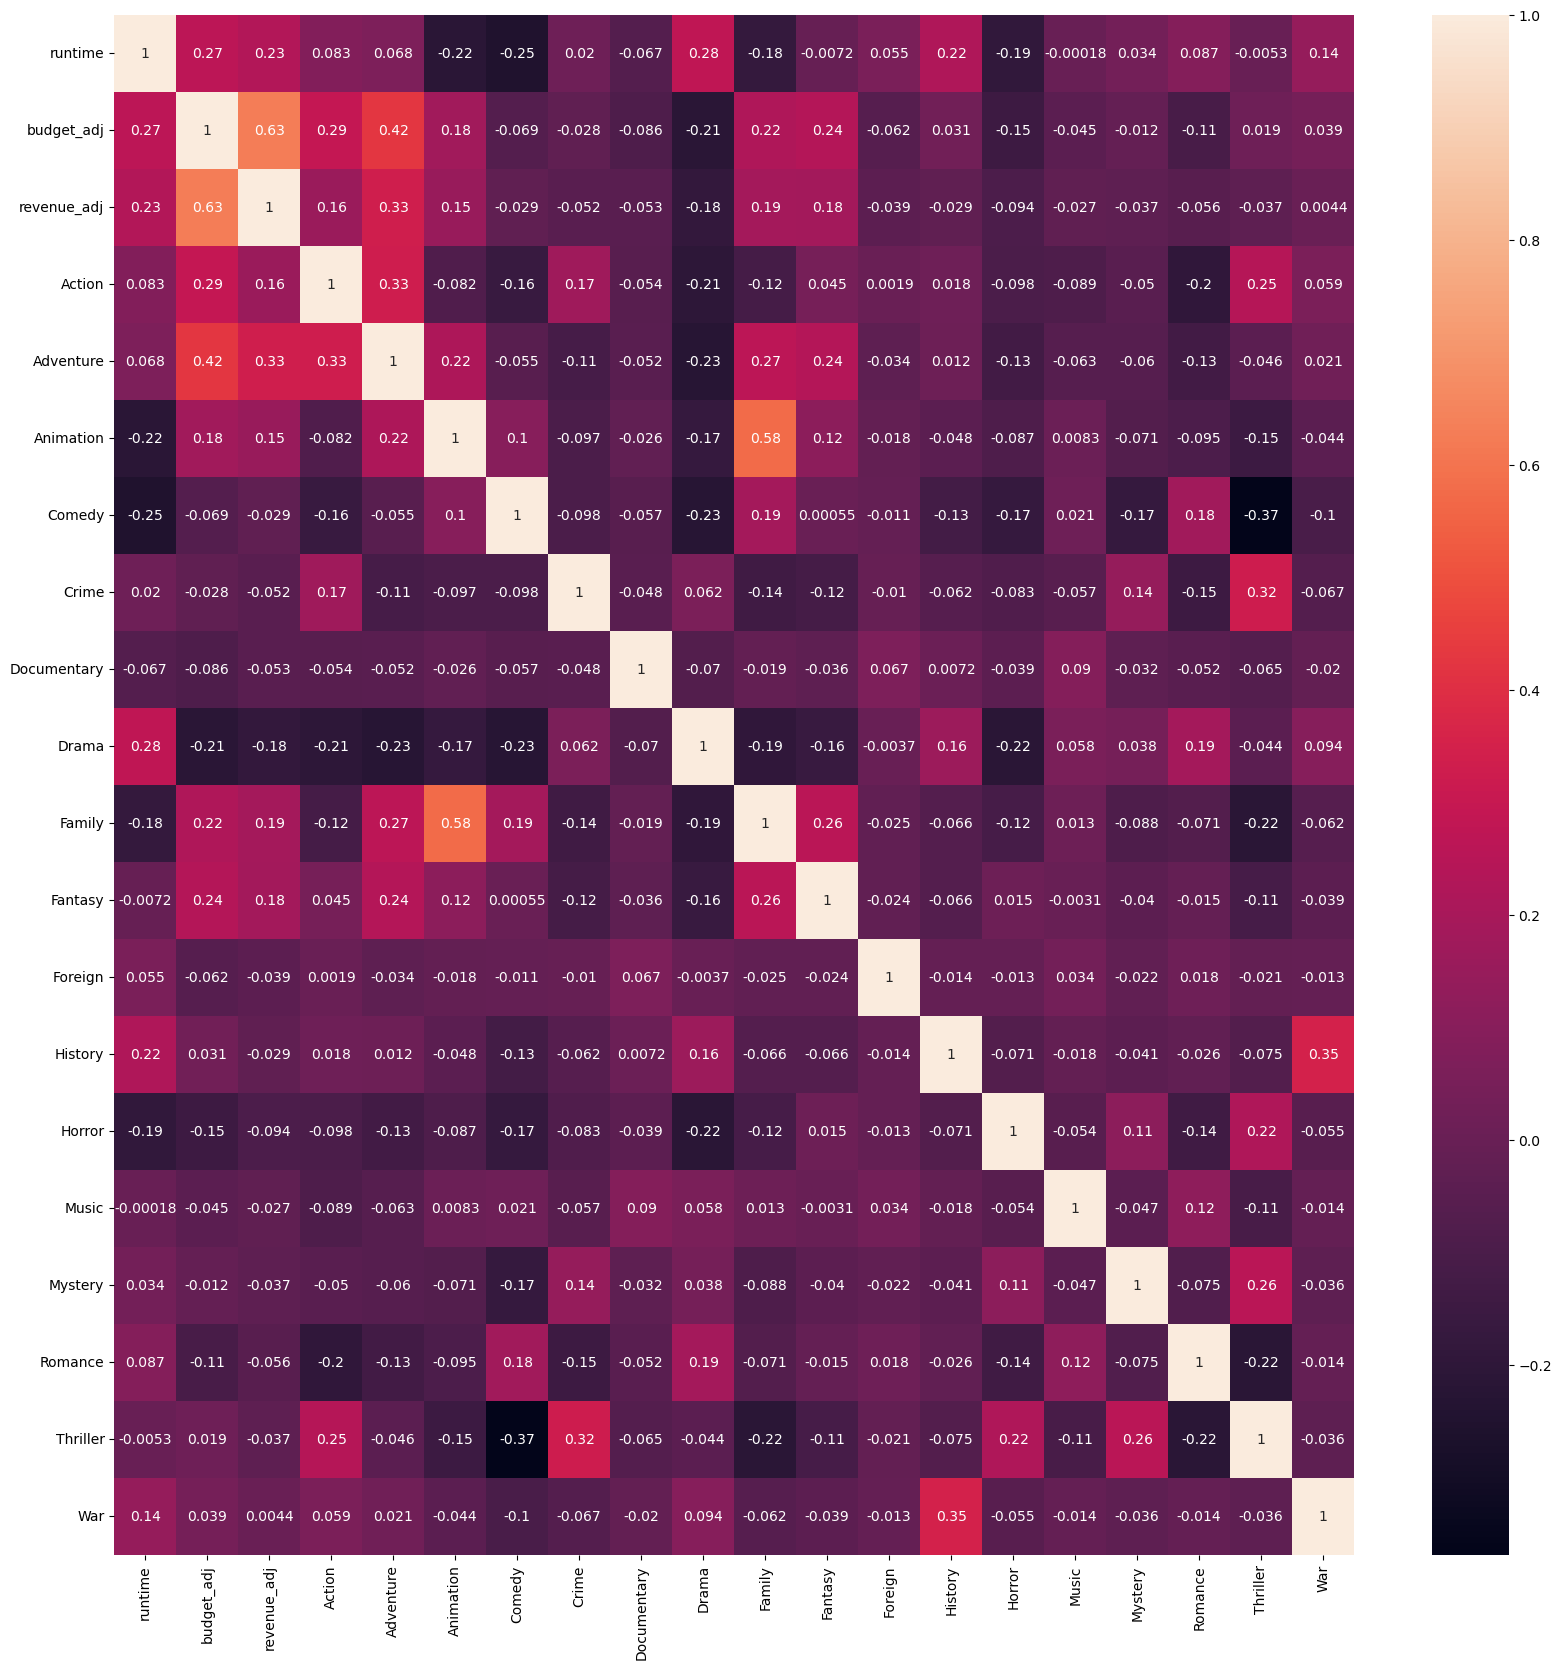

In [11]:
# Zoom in the first 20 variables
plt.figure(figsize = (20,20))
sns.heatmap(matrix.iloc[:20,:20],annot = True)

Correlation > 0.5:
- budget_adj & revenue_adj : 0.63
- family & animation : 0.58 
<br>We will keep these variables as they are not highly correlated (>0.8).

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'United States of America'),
  Text(1.5, 0, 'United Kingdom'),
  Text(2.5, 0, 'France'),
  Text(3.5, 0, 'Germany'),
  Text(4.5, 0, 'Canada'),
  Text(5.5, 0, 'India'),
  Text(6.5, 0, 'Australia'),
  Text(7.5, 0, 'Italy'),
  Text(8.5, 0, 'Russia'),
  Text(9.5, 0, 'Japan'),
  Text(10.5, 0, 'Other Country')])

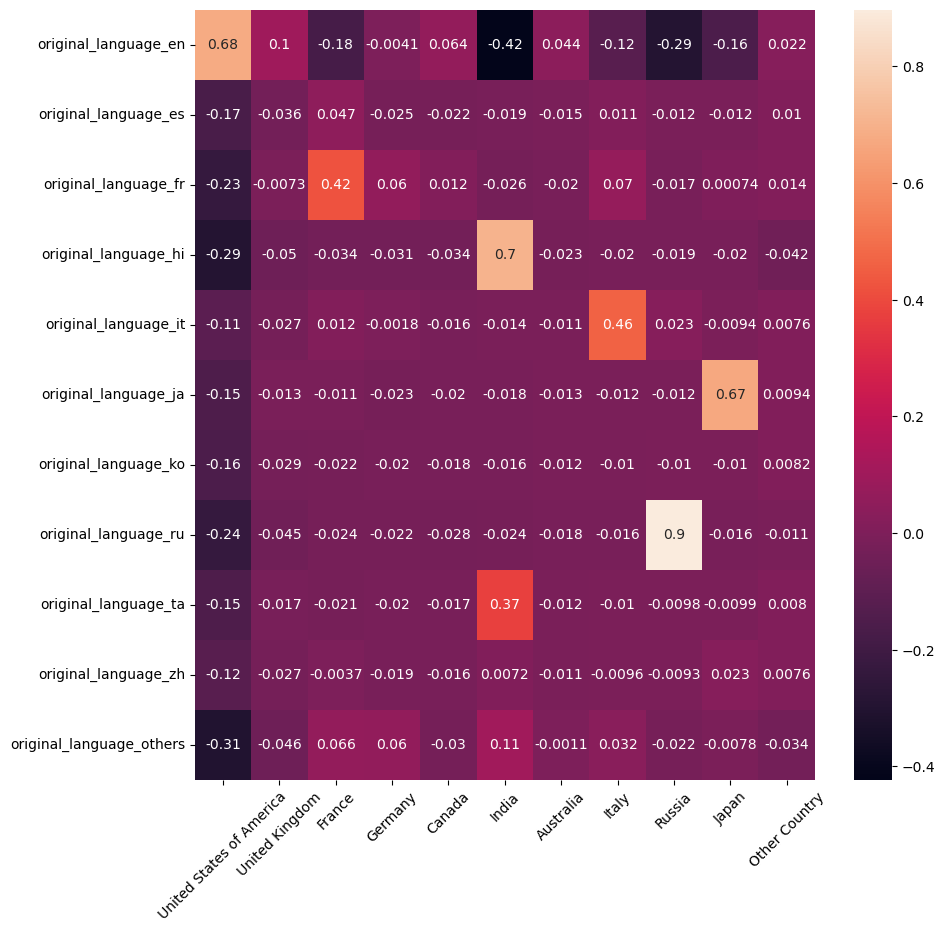

In [12]:
# Zoom in to the production country against language variables
plt.figure(figsize = (10,10))
sns.heatmap(matrix.iloc[21:32,43:54],annot = True)
plt.xticks(rotation=45)

Correlation > 0.5:
- Production country and corresponding language (highly correlated >0.8 for original_language_ru and Russia)
<br>We will remove the production country variables.

### Drop production country column

In [13]:
train.drop(["United States of America", "United Kingdom","France","Germany",
            "Canada","India","Australia","Italy","Russia","Japan","Other Country"], axis=1, inplace=True)

test.drop(["United States of America", "United Kingdom","France","Germany",
            "Canada","India","Australia","Italy","Russia","Japan","Other Country"], axis=1, inplace=True)

(array([0.5, 1.5]), [Text(0.5, 0, 'series_num'), Text(1.5, 0, 'series_ind')])

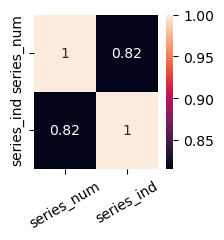

In [14]:
# Zoom in to series_num and series_ind
plt.figure(figsize = (2,2))
sns.heatmap(matrix.iloc[58:60,58:60],annot = True)
plt.xticks(rotation=30)

Series_num and series_ind are highly correlated (>0.8). We will only consider series_num for our model.

### Drop series_ind column

In [15]:
train.drop(["series_ind"], axis=1, inplace=True)
test.drop(["series_ind"], axis=1, inplace=True)

### Checking correlation matrix for all x variables against y target variable

In [16]:
matrix[matrix["revenue_adj"]>0.5]

runtime  budget_adj  revenue_adj    Action  Adventure  \
budget_adj   0.267296    1.000000     0.630912  0.289922   0.424306   
revenue_adj  0.234604    0.630912     1.000000  0.159952   0.334186   

             Animation    Comedy     Crime  Documentary     Drama  ...  \
budget_adj    0.178098 -0.069382 -0.027586    -0.086226 -0.214477  ...   
revenue_adj   0.153630 -0.029148 -0.052184    -0.052681 -0.183321  ...   

             Topic_Topic 1  Topic_Topic 10  Topic_Topic 2  Topic_Topic 3  \
budget_adj       -0.080298       -0.070591      -0.134882      -0.129644   
revenue_adj      -0.083425       -0.058779      -0.073350      -0.076213   

             Topic_Topic 4  Topic_Topic 5  Topic_Topic 6  Topic_Topic 7  \
budget_adj        0.017207       -0.04706       0.273405       0.158210   
revenue_adj       0.005053       -0.04921       0.183872       0.094822   

             Topic_Topic 8  Topic_Topic 9  
budget_adj        0.118109      -0.054595  
revenue_adj       0.115995      -0.021900  

[2 rows x 73 columns]

From the correlation above, only budget_adj has more than 0.5 correlation againts revenue.

### Check the distribution of all variables

In [17]:
train.iloc[:,:20].describe()

runtime    budget_adj   revenue_adj       Action    Adventure  \
count  3389.000000  3.389000e+03  3.389000e+03  3389.000000  3389.000000   
mean    109.143110  5.652657e+07  1.675304e+08     0.266450     0.182060   
std      20.637748  6.182463e+07  2.998767e+08     0.442168     0.385951   
min       0.000000  1.063060e+00  1.063060e+00     0.000000     0.000000   
25%      95.000000  1.148510e+07  1.282871e+07     0.000000     0.000000   
50%     105.000000  3.397547e+07  5.759904e+07     0.000000     0.000000   
75%     120.000000  8.003981e+07  1.882649e+08     1.000000     0.000000   
max     214.000000  4.464082e+08  4.850569e+09     1.000000     1.000000   

         Animation       Comedy        Crime  Documentary        Drama  \
count  3389.000000  3389.000000  3389.000000  3389.000000  3389.000000   
mean      0.055474     0.349366     0.163470     0.011803     0.470050   
std       0.228936     0.476840     0.369849     0.108014     0.499176   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Family      Fantasy      Foreign      History       Horror  \
count  3389.000000  3389.000000  3389.000000  3389.000000  3389.000000   
mean      0.101505     0.099439     0.005311     0.037474     0.113308   
std       0.302041     0.299295     0.072696     0.189949     0.317015   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             Music      Mystery      Romance     Thriller          War  
count  3389.000000  3389.000000  3389.000000  3389.000000  3389.000000  
mean      0.031278     0.079965     0.184125     0.298908     0.032458  
std       0.174093     0.271278     0.387643     0.457847     0.177239  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     1.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [18]:
train.iloc[:,20:40].describe()

Western  original_language_en  original_language_es  \
count  3389.000000           3389.000000           3389.000000   
mean      0.007967              0.882856              0.008852   
std       0.088915              0.321639              0.093682   
min       0.000000              0.000000              0.000000   
25%       0.000000              1.000000              0.000000   
50%       0.000000              1.000000              0.000000   
75%       0.000000              1.000000              0.000000   
max       1.000000              1.000000              1.000000   

       original_language_fr  original_language_hi  original_language_it  \
count           3389.000000           3389.000000           3389.000000   
mean               0.016524              0.021540              0.005016   
std                0.127498              0.145198              0.070658   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       original_language_ja  original_language_ko  original_language_ru  \
count           3389.000000           3389.000000           3389.000000   
mean               0.007672              0.005901              0.014163   
std                0.087266              0.076605              0.118182   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       original_language_ta  original_language_zh  original_language_others  \
count           3389.000000           3389.000000               3389.000000   
mean               0.005606              0.005016                  0.026852   
std                0.074677              0.070658                  0.161673   
min                0.000000              0.000000                  0.000000   
25%                0.000000              0.000000                  0.000000   
50%                0.000000              0.000000                  0.000000   
75%                0.000000              0.000000                  0.000000   
max                1.000000              1.000000                  1.000000   

       Warner Bros.  Universal Pictures  Paramount Pictures  \
count   3389.000000         3389.000000         3389.000000   
mean       0.076424            0.071407            0.053703   
std        0.265714            0.257542            0.225464   
min        0.000000            0.000000            0.000000   
25%        0.000000            0.000000            0.000000   
50%        0.000000            0.000000            0.000000   
75%        0.000000            0.000000            0.000000   
max        1.000000            1.000000            1.000000   

       Twentieth Century Fox Film Corporation  Columbia Pictures  \
count                             3389.000000        3389.000000   
mean                                 0.050752           0.036884   
std                                  0.219524           0.188505   
min                                  0.000000           0.000000   
25%                                  0.000000           0.000000   
50%                                  0.000000           0.000000   
75%                                  0.000000           0.000000   
max                                  1.000000           1.000000   

       New Line Cinema  Walt Disney Pictures  Touchstone Pictures  
count       3389.00000           3389.000000          3389.000000  
mean           0.04072             

In [19]:
train.iloc[:,40:60].describe()

Relativity Media  Metro-Goldwyn-Mayer (MGM)   Other Prod    quarter_1  \
count       3389.000000                3389.000000  3389.000000  3389.000000   
mean           0.023016                   0.021835     0.961641     0.210682   
std            0.149975                   0.146167     0.192091     0.407853   
min            0.000000                   0.000000     0.000000     0.000000   
25%            0.000000                   0.000000     1.000000     0.000000   
50%            0.000000                   0.000000     1.000000     0.000000   
75%            0.000000                   0.000000     1.000000     0.000000   
max            1.000000                   1.000000     1.000000     1.000000   

         quarter_2    quarter_3    quarter_4   series_num  total_popular_cast  \
count  3389.000000  3389.000000  3389.000000  3389.000000         3389.000000   
mean      0.235468     0.286515     0.267335     0.576866            0.170847   
std       0.424353     0.452200     0.442634     1.617060            0.429876   
min       0.000000     0.000000     0.000000     0.000000            0.000000   
25%       0.000000     0.000000     0.000000     0.000000            0.000000   
50%       0.000000     0.000000     0.000000     0.000000            0.000000   
75%       0.000000     1.000000     1.000000     0.000000            0.000000   
max       1.000000     1.000000     1.000000    14.000000            4.000000   

       top_director   total_cast  Topic_Topic 1  Topic_Topic 10  \
count   3389.000000  3389.000000    3389.000000     3389.000000   
mean       0.156093    23.714075       0.137799        0.075834   
std        0.362997    20.490142       0.344740        0.264771   
min        0.000000     0.000000       0.000000        0.000000   
25%        0.000000    12.000000       0.000000        0.000000   
50%        0.000000    17.000000       0.000000        0.000000   
75%        0.000000    27.000000       0.000000        0.000000   
max        1.000000   224.000000       1.000000        1.000000   

       Topic_Topic 2  Topic_Topic 3  Topic_Topic 4  Topic_Topic 5  \
count    3389.000000    3389.000000    3389.000000    3389.000000   
mean        0.121570       0.120389       0.106816       0.094128   
std         0.326836       0.325464       0.308925       0.292050   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       Topic_Topic 6  Topic_Topic 7  Topic_Topic 8  
count    3389.000000    3389.000000    3389.000000  
mean        0.091472       0.085276       0.085276  
std         0.288322       0.279333       0.279333  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000

In [20]:
train.iloc[:,60:].describe()

Topic_Topic 9
count     3389.00000
mean         0.08144
std          0.27355
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000

Variables that need to be further investigated:
- budget_adj and revenue_adj - may need transformation since value is too big compared to others.
- runtime & total_cast - may need scaling

### Plot of budget_adj and revenue_adj

Text(0, 0.5, 'Frequency')

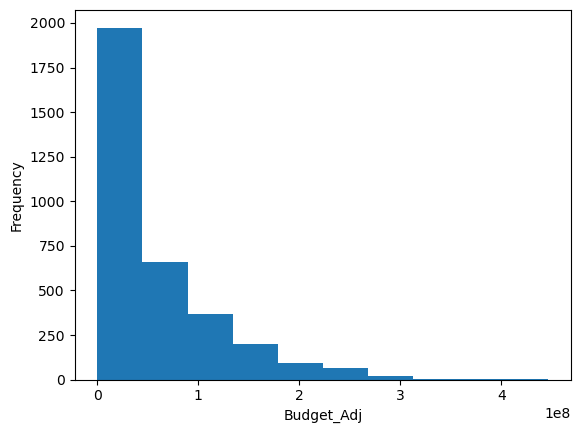

In [21]:
plt.hist(train['budget_adj'], bins=10)
plt.xlabel("Budget_Adj")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

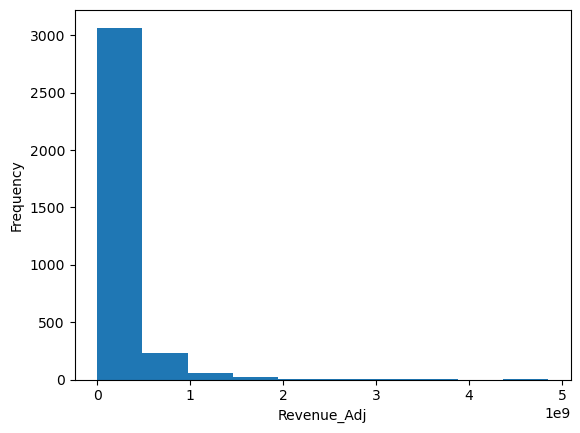

In [22]:
plt.hist(train['revenue_adj'], bins=10)
plt.xlabel("Revenue_Adj")
plt.ylabel("Frequency")

By applying a log transformation, the skewness can be reduced and the data can bring down the large values of budget_adj and revenue_adj.

Text(0, 0.5, 'Frequency')

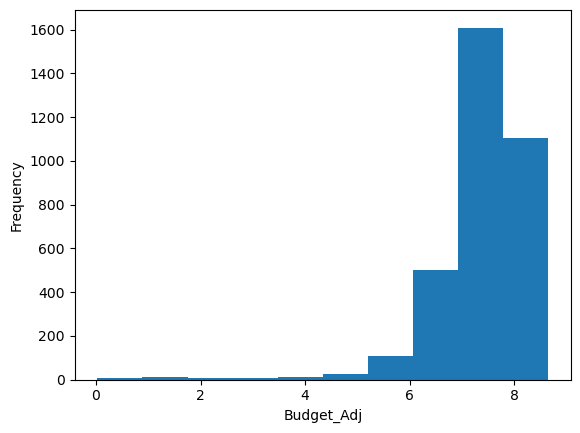

In [23]:
plt.hist(np.log10(train['budget_adj']), bins=10)
plt.xlabel("Budget_Adj")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

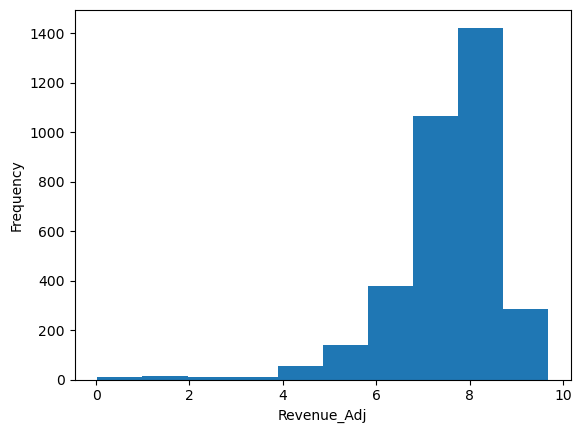

In [24]:
plt.hist(np.log10(train['revenue_adj']), bins=10)
plt.xlabel("Revenue_Adj")
plt.ylabel("Frequency")

### Scatterplot of budget_adj and revenue_adj

C:\Users\Tina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


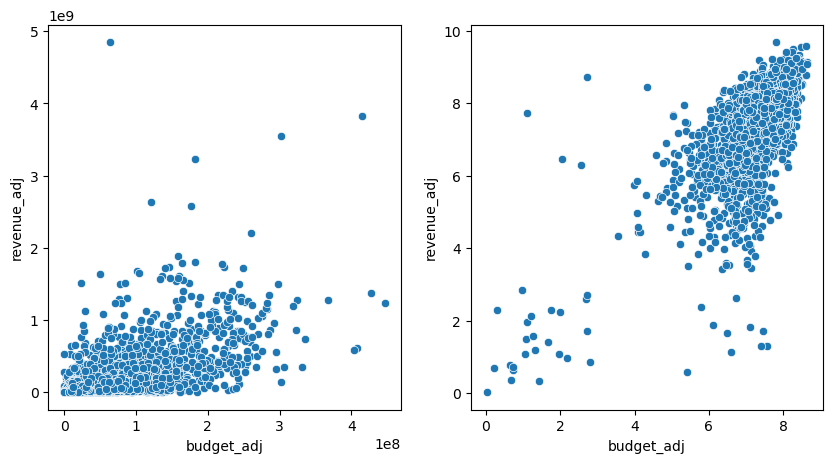

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(train['budget_adj'],train['revenue_adj'])
plt.subplot(1,2,2)

# Check the distribution after performing log transformation
sns.scatterplot(np.log10(train['budget_adj']),np.log10(train['revenue_adj']))
plt.show()

### Log Transformation for budget_adj and revenue_adj

In [26]:
# Log Transformation for budget_adj and revenue_adj

train['budget_adj']=np.log10(train['budget_adj'])
test['budget_adj']=np.log10(test['budget_adj'])
train['revenue_adj']=np.log10(train['revenue_adj'])
test['revenue_adj']=np.log10(test['revenue_adj'])

In [27]:
train.corr()[train.corr()["revenue_adj"]>0.5]

runtime  budget_adj  revenue_adj    Action  Adventure  \
budget_adj   0.163874    1.000000     0.731668  0.198890   0.257791   
revenue_adj  0.196477    0.731668     1.000000  0.152987   0.234232   

             Animation    Comedy     Crime  Documentary     Drama  ...  \
budget_adj    0.110391 -0.030754  0.036933    -0.158363 -0.136870  ...   
revenue_adj   0.112979 -0.004914  0.001519    -0.112126 -0.169822  ...   

             Topic_Topic 1  Topic_Topic 10  Topic_Topic 2  Topic_Topic 3  \
budget_adj       -0.017292       -0.025009      -0.111803      -0.086802   
revenue_adj      -0.037455       -0.024128      -0.060506      -0.062548   

             Topic_Topic 4  Topic_Topic 5  Topic_Topic 6  Topic_Topic 7  \
budget_adj       -0.004066      -0.032140       0.175567       0.098250   
revenue_adj       0.008695      -0.063791       0.147328       0.090289   

             Topic_Topic 8  Topic_Topic 9  
budget_adj        0.078018      -0.043280  
revenue_adj       0.067211      -0.040562  

[2 rows x 61 columns]

### Histogram of runtime and total_cast to check the correlation

(array([6.000e+00, 1.000e+00, 1.000e+00, 1.870e+02, 1.591e+03, 1.094e+03,
        3.470e+02, 1.230e+02, 2.900e+01, 1.000e+01]),
 array([  0. ,  21.4,  42.8,  64.2,  85.6, 107. , 128.4, 149.8, 171.2,
        192.6, 214. ]),
 <BarContainer object of 10 artists>)

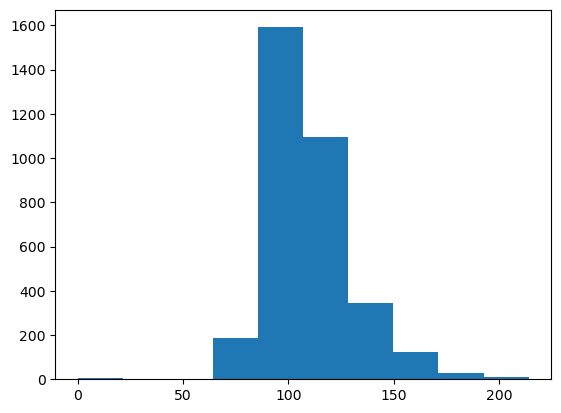

In [28]:
plt.hist(train['runtime'], bins=10)

(array([2247.,  776.,  225.,   80.,   30.,   15.,    7.,    6.,    0.,
           3.]),
 array([  0. ,  22.4,  44.8,  67.2,  89.6, 112. , 134.4, 156.8, 179.2,
        201.6, 224. ]),
 <BarContainer object of 10 artists>)

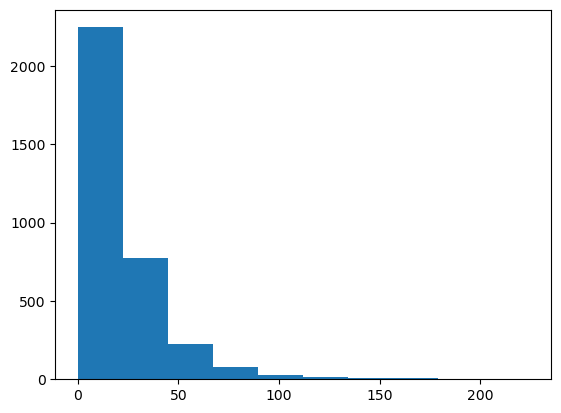

In [29]:
plt.hist(train['total_cast'], bins=10)

### Scaling using Standard Scaler for runtime,  total_cast, total_popular_cast, and series_num

In [30]:
rscaler = StandardScaler()
rscaler.fit(train[['runtime']])
train['runtime'] = rscaler.transform(train[['runtime']])
test['runtime'] = rscaler.transform(test[['runtime']])

In [31]:
cscaler = StandardScaler()
cscaler.fit(train[['total_cast']])
train['total_cast'] = cscaler.transform(train[['total_cast']])
test['total_cast'] = cscaler.transform(test[['total_cast']])

In [32]:
sscaler = StandardScaler()
sscaler.fit(train[['series_num']])
train['series_num'] = sscaler.transform(train[['series_num']])
test['series_num'] = sscaler.transform(test[['series_num']])

In [33]:
pcscaler = StandardScaler()
pcscaler.fit(train[['total_popular_cast']])
train['total_popular_cast'] = pcscaler.transform(train[['total_popular_cast']])
test['total_popular_cast'] = pcscaler.transform(test[['total_popular_cast']])

### Final check on train and test data set before building model

In [34]:
train.iloc[:,:20].describe()

runtime   budget_adj  revenue_adj       Action    Adventure  \
count  3.389000e+03  3389.000000  3389.000000  3389.000000  3389.000000   
mean   1.789985e-16     7.376805     7.534502     0.266450     0.182060   
std    1.000148e+00     0.861253     1.154643     0.442168     0.385951   
min   -5.289299e+00     0.026558     0.026558     0.000000     0.000000   
25%   -6.854041e-01     7.060135     7.108183     0.000000     0.000000   
50%   -2.007836e-01     7.531165     7.760415     0.000000     0.000000   
75%    5.261471e-01     7.903306     8.274769     1.000000     0.000000   
max    5.081580e+00     8.649732     9.685793     1.000000     1.000000   

         Animation       Comedy        Crime  Documentary        Drama  \
count  3389.000000  3389.000000  3389.000000  3389.000000  3389.000000   
mean      0.055474     0.349366     0.163470     0.011803     0.470050   
std       0.228936     0.476840     0.369849     0.108014     0.499176   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Family      Fantasy      Foreign      History       Horror  \
count  3389.000000  3389.000000  3389.000000  3389.000000  3389.000000   
mean      0.101505     0.099439     0.005311     0.037474     0.113308   
std       0.302041     0.299295     0.072696     0.189949     0.317015   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             Music      Mystery      Romance     Thriller          War  
count  3389.000000  3389.000000  3389.000000  3389.000000  3389.000000  
mean      0.031278     0.079965     0.184125     0.298908     0.032458  
std       0.174093     0.271278     0.387643     0.457847     0.177239  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     1.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [35]:
train.iloc[:,20:40].describe()

Western  original_language_en  original_language_es  \
count  3389.000000           3389.000000           3389.000000   
mean      0.007967              0.882856              0.008852   
std       0.088915              0.321639              0.093682   
min       0.000000              0.000000              0.000000   
25%       0.000000              1.000000              0.000000   
50%       0.000000              1.000000              0.000000   
75%       0.000000              1.000000              0.000000   
max       1.000000              1.000000              1.000000   

       original_language_fr  original_language_hi  original_language_it  \
count           3389.000000           3389.000000           3389.000000   
mean               0.016524              0.021540              0.005016   
std                0.127498              0.145198              0.070658   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       original_language_ja  original_language_ko  original_language_ru  \
count           3389.000000           3389.000000           3389.000000   
mean               0.007672              0.005901              0.014163   
std                0.087266              0.076605              0.118182   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       original_language_ta  original_language_zh  original_language_others  \
count           3389.000000           3389.000000               3389.000000   
mean               0.005606              0.005016                  0.026852   
std                0.074677              0.070658                  0.161673   
min                0.000000              0.000000                  0.000000   
25%                0.000000              0.000000                  0.000000   
50%                0.000000              0.000000                  0.000000   
75%                0.000000              0.000000                  0.000000   
max                1.000000              1.000000                  1.000000   

       Warner Bros.  Universal Pictures  Paramount Pictures  \
count   3389.000000         3389.000000         3389.000000   
mean       0.076424            0.071407            0.053703   
std        0.265714            0.257542            0.225464   
min        0.000000            0.000000            0.000000   
25%        0.000000            0.000000            0.000000   
50%        0.000000            0.000000            0.000000   
75%        0.000000            0.000000            0.000000   
max        1.000000            1.000000            1.000000   

       Twentieth Century Fox Film Corporation  Columbia Pictures  \
count                             3389.000000        3389.000000   
mean                                 0.050752           0.036884   
std                                  0.219524           0.188505   
min                                  0.000000           0.000000   
25%                                  0.000000           0.000000   
50%                                  0.000000           0.000000   
75%                                  0.000000           0.000000   
max                                  1.000000           1.000000   

       New Line Cinema  Walt Disney Pictures  Touchstone Pictures  
count       3389.00000           3389.000000          3389.000000  
mean           0.04072             

In [36]:
train.iloc[:,40:60].describe()

Relativity Media  Metro-Goldwyn-Mayer (MGM)   Other Prod    quarter_1  \
count       3389.000000                3389.000000  3389.000000  3389.000000   
mean           0.023016                   0.021835     0.961641     0.210682   
std            0.149975                   0.146167     0.192091     0.407853   
min            0.000000                   0.000000     0.000000     0.000000   
25%            0.000000                   0.000000     1.000000     0.000000   
50%            0.000000                   0.000000     1.000000     0.000000   
75%            0.000000                   0.000000     1.000000     0.000000   
max            1.000000                   1.000000     1.000000     1.000000   

         quarter_2    quarter_3    quarter_4    series_num  \
count  3389.000000  3389.000000  3389.000000  3.389000e+03   
mean      0.235468     0.286515     0.267335 -2.104477e-16   
std       0.424353     0.452200     0.442634  1.000148e+00   
min       0.000000     0.000000     0.000000 -3.567903e-01   
25%       0.000000     0.000000     0.000000 -3.567903e-01   
50%       0.000000     0.000000     0.000000 -3.567903e-01   
75%       0.000000     1.000000     1.000000 -3.567903e-01   
max       1.000000     1.000000     1.000000  8.302173e+00   

       total_popular_cast  top_director    total_cast  Topic_Topic 1  \
count        3.389000e+03   3389.000000  3.389000e+03    3389.000000   
mean         3.932135e-16      0.156093  8.845093e-18       0.137799   
std          1.000148e+00      0.362997  1.000148e+00       0.344740   
min         -3.974916e-01      0.000000 -1.157511e+00       0.000000   
25%         -3.974916e-01      0.000000 -5.717776e-01       0.000000   
50%         -3.974916e-01      0.000000 -3.277218e-01       0.000000   
75%         -3.974916e-01      0.000000  1.603898e-01       0.000000   
max          8.908893e+00      1.000000  9.776188e+00       1.000000   

       Topic_Topic 10  Topic_Topic 2  Topic_Topic 3  Topic_Topic 4  \
count     3389.000000    3389.000000    3389.000000    3389.000000   
mean         0.075834       0.121570       0.120389       0.106816   
std          0.264771       0.326836       0.325464       0.308925   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max          1.000000       1.000000       1.000000       1.000000   

       Topic_Topic 5  Topic_Topic 6  Topic_Topic 7  Topic_Topic 8  
count    3389.000000    3389.000000    3389.000000    3389.000000  
mean        0.094128       0.091472       0.085276       0.085276  
std         0.292050       0.288322       0.279333       0.279333  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000

In [37]:
train.iloc[:,60:].describe()

Topic_Topic 9
count     3389.00000
mean         0.08144
std          0.27355
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000

In [38]:
train.head()

runtime  budget_adj  revenue_adj  Action  Adventure  Animation  Comedy  \
0  0.235375    7.716683     7.661262       0          0          0       0   
1 -0.103860    7.894824     8.631821       1          1          0       0   
2  1.786160    7.980954     8.150959       0          0          0       0   
3 -0.782328    5.937485     5.415407       0          0          0       0   
4  0.768457    6.940909     7.759432       1          0          0       1   

   Crime  Documentary  Drama  ...  Topic_Topic 1  Topic_Topic 10  \
0      1            0      0  ...            0.0             0.0   
1      0            0      0  ...            0.0             0.0   
2      0            0      1  ...            0.0             0.0   
3      0            0      1  ...            1.0             0.0   
4      0            0      1  ...            1.0             0.0   

   Topic_Topic 2  Topic_Topic 3  Topic_Topic 4  Topic_Topic 5  Topic_Topic 6  \
0            0.0            1.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   Topic_Topic 7  Topic_Topic 8  Topic_Topic 9  
0            0.0            0.0            0.0  
1            1.0            0.0            0.0  
2            0.0            0.0            1.0  
3            0.0            0.0            0.0  
4            0.0            0.0            0.0  

[5 rows x 61 columns]

In [39]:
train.columns

Index(['runtime', 'budget_adj', 'revenue_adj', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Thriller', 'War', 'Western', 'original_language_en',
       'original_language_es', 'original_language_fr', 'original_language_hi',
       'original_language_it', 'original_language_ja', 'original_language_ko',
       'original_language_ru', 'original_language_ta', 'original_language_zh',
       'original_language_others', 'Warner Bros.', 'Universal Pictures',
       'Paramount Pictures', 'Twentieth Century Fox Film Corporation',
       'Columbia Pictures', 'New Line Cinema', 'Walt Disney Pictures',
       'Touchstone Pictures', 'Relativity Media', 'Metro-Goldwyn-Mayer (MGM)',
       'Other Prod', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4',
       'series_num', 'total_popular_cast', 'top_director', 'total_cast',
       'Topic_Topic 1', 'Topic_Topic 1

In [40]:
# Check Multicollinearity with VIF

In [41]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(x_train)

# Multicollinearity check (VIF)
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print diagnostics results
print("Variance Inflation Factor (VIF):")
print(vif[:20])
print(vif[20:40])
print(vif[40:])

C:\Users\Tina\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Tina\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
       Features       VIF
0         const  0.000000
1       runtime  1.863422
2    budget_adj  1.622958
3        Action  1.591527
4     Adventure  1.530676
5     Animation  1.700193
6        Comedy  1.632459
7         Crime  1.392813
8   Documentary  1.129724
9         Drama  1.603757
10       Family  1.936930
11      Fantasy  1.243207
12      Foreign  1.070789
13      History  1.251668
14       Horror  1.495645
15        Music  1.162048
16      Mystery  1.151485
17      Romance  1.243016
18     Thriller  1.620263
19          War  1.236462
                                  Features       VIF
20                                 Western  1.031716
21                    original_language_en       inf
22                    original_language_es       inf
23                    original_language_fr       inf
24                    original_language_hi       inf
25                    original_language_it       inf
26                    original_language_ja       i

Infinity VIF refers to perfect multicollinearity meaning  means that one or more independent variables in the model can be perfectly predicted using a linear combination of the other independent variables. After one-hot encoded, one of the column should be removed.

In [42]:
### Drop column: original_language_others, quarter_4, Topic_Topic 10 to avoid perfect multicollinearity
train.drop(["original_language_others"], axis=1, inplace=True)
test.drop(["original_language_others"], axis=1, inplace=True)

train.drop(["quarter_4"], axis=1, inplace=True)
test.drop(["quarter_4"], axis=1, inplace=True)

train.drop(["Topic_Topic 10"], axis=1, inplace=True)
test.drop(["Topic_Topic 10"], axis=1, inplace=True)

### Linear Regression Model with data scaling&transformation, remove highly correlated variables /unnecessary column

In [43]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]


# Build a linear regression using default parameters
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred_train = regr.predict(x_train)
y_pred_test = regr.predict(x_test)

print('Intercept:', regr.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': regr.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
print(regr.coef_)
top10_features = coefficients_df.head(10)  # Change the number as needed
print(top10_features)

def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))
    
print("Average Revenue:", np.average(y_test))
print("Standard Deviation Revenue:", np.std(y_test))
    
print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))


print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))



# # Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
# rsquared = r2_score(y_test, y_pred)
# n, p = len(y_test), np.shape(X_test)[1]

# print("r-squared:", rsquared, "; adjusted r-squared:", adj_rsquared)

Intercept: 0.8923003978169994
[ 0.09364102  0.83629483 -0.02566913  0.01522787  0.15942637  0.03543273
  0.03034062  0.20853662 -0.12027114  0.14599876 -0.04394468 -0.299764
 -0.07440995  0.16735777 -0.11211763 -0.04893151  0.0467558  -0.02026546
  0.00926614 -0.16499781 -0.01557474  0.1493462  -0.21575271  0.29890156
 -0.11637694  0.26620153  0.56779693 -0.02895507  0.3400958   0.09088448
  0.19727103  0.2921336   0.28733645  0.3225468   0.25438234  0.26422646
  0.31046638  0.23747859  0.10829015  0.05237815  0.37307517  0.02240149
  0.05372397  0.03857405  0.1371032   0.02444175  0.1745251   0.06792989
 -0.09779833  0.09094239  0.01306785  0.00234586 -0.11387921 -0.08522846
 -0.02869238 -0.06023216 -0.06171647]
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.836295              0.836295
26                    original_language_ko     0.567797              0.567797
40                              Other Prod 

### Feature Selection Stepwise: Backward

In [44]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]


# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(x_train)

# Fit the initial model (with all features)
model = sm.OLS(y_train, X).fit()

# Start the stepwise backward selection process
while True:
    # Get the p-values of the current model's coefficients
    p_values = model.pvalues[1:]  # Exclude the constant term

    # Find the variable with the highest p-value
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        # Remove the variable with the highest p-value from the model
        variable_to_remove = p_values.idxmax()
        X = X.drop(variable_to_remove, axis=1)

        # Fit the updated model without the removed variable
        model = sm.OLS(y_train, X).fit()
    else:
        break

# Print the summary of the final model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            revenue_adj   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     220.5
Date:                Sun, 02 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:28:01   Log-Likelihood:                -3738.0
No. Observations:                3389   AIC:                             7524.
Df Residuals:                    3365   BIC:                             7671.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### Use stepwise backward x-variables

In [45]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

x_train= x_train[["runtime","budget_adj","Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                  "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                  "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                  "Walt Disney Pictures","Touchstone Pictures","Other Prod", 
                   "series_num","top_director","total_cast","Topic_Topic 2"]]

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

x_test = x_test[["runtime","budget_adj","Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                  "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                  "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                  "Walt Disney Pictures","Touchstone Pictures","Other Prod", 
                   "series_num","top_director","total_cast","Topic_Topic 2"]]


# Define y_test
y_test = test["revenue_adj"]

# Build a linear regression using default parameters
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred_train = regr.predict(x_train)
y_pred_test = regr.predict(x_test)

print('Intercept:', regr.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': regr.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))
    
print("Average Revenue:", np.average(y_test))
print("Standard Deviation Revenue:", np.std(y_test))
    
print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))


print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Intercept: 0.92126696518232
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.826385              0.826385
9                     original_language_ko     0.527311              0.527311
18                              Other Prod     0.373902              0.373902
13  Twentieth Century Fox Film Corporation     0.315010              0.315010
16                    Walt Disney Pictures     0.314051              0.314051
11                      Universal Pictures     0.299071              0.299071
12                      Paramount Pictures     0.280949              0.280949
8                     original_language_hi     0.266701              0.266701
14                       Columbia Pictures     0.257983              0.257983
15                         New Line Cinema     0.250926              0.250926
Average Revenue: 7.521374024601831
Standard Deviation Revenue: 1.165548020137768
Train RMSE 0.7290

### Plot actual vs predicted for best model

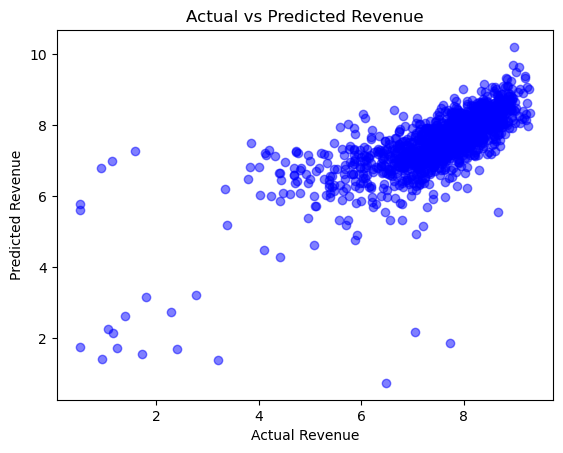

In [46]:
# Plotting actual revenue vs predicted revenue
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

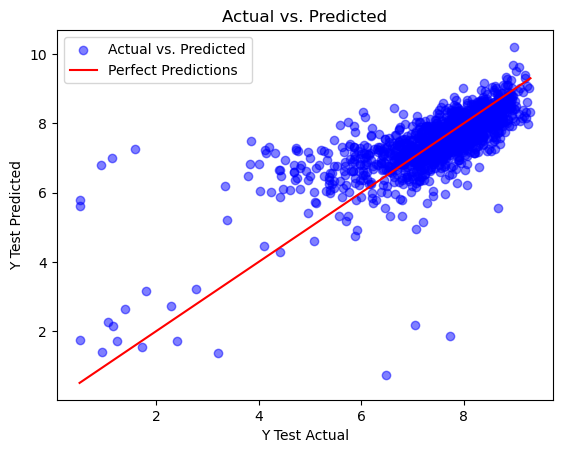

In [47]:
import matplotlib.pyplot as plt

# Assuming you have actual and predicted values stored in 'y_actual' and 'y_predicted' respectively

# Plot the scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5, label='Actual vs. Predicted')

# Plot the diagonal line representing perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Predictions')

# Set labels and title
plt.xlabel('Y Test Actual')
plt.ylabel('Y Test Predicted')
plt.title('Actual vs. Predicted')

# Set legend
plt.legend()

# Display the plot
plt.show()


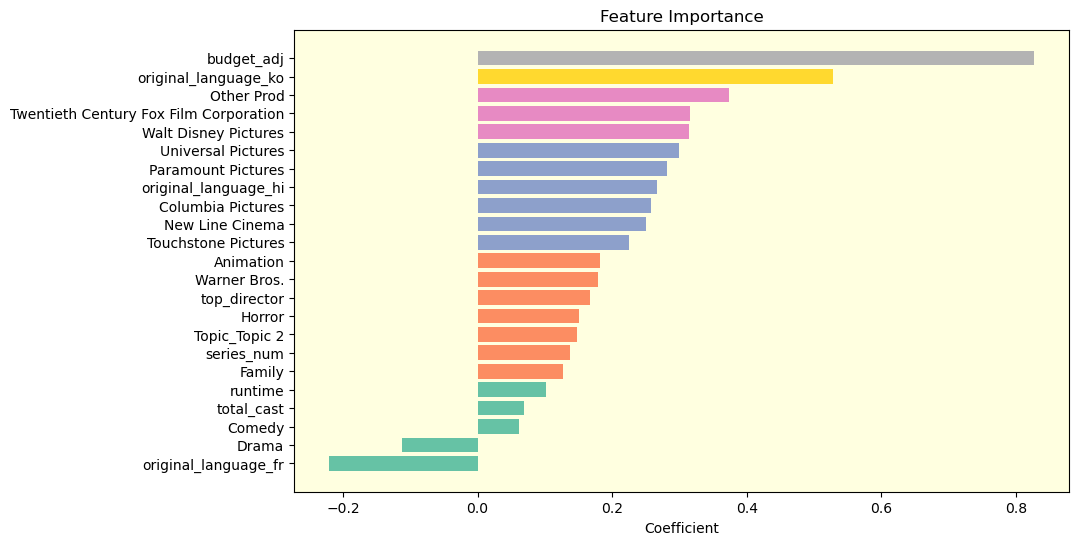

In [48]:
# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=True)

# Generate colors for the bars using 'viridis' colormap
colors = plt.cm.Set2(coefficients_df['Coefficient'] / max(coefficients_df['Coefficient']))

# Create the horizontal bar chart with light yellow background color
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor('lightyellow')
ax.barh(np.arange(len(coefficients_df)), coefficients_df['Coefficient'], color=colors)

# Set y-axis tick labels to feature names
ax.set_yticks(np.arange(len(coefficients_df)))
ax.set_yticklabels(coefficients_df['Feature'])

# Set x-axis label and title
ax.set_xlabel('Coefficient')
ax.set_title('Feature Importance')

# Display the plot
plt.show()

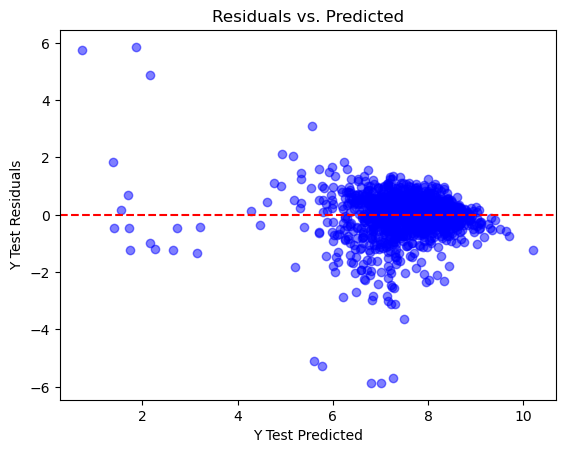

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have actual and predicted values stored in 'y_actual' and 'y_predicted' respectively

# Calculate the residuals
residuals = y_test - y_pred_test

# Plot the residuals against the predicted values
plt.scatter(y_pred_test, residuals, color='blue', alpha=0.5)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='red', linestyle='--')

# Set labels and title
plt.xlabel('Y Test Predicted')
plt.ylabel('Y Test Residuals')
plt.title('Residuals vs. Predicted')

# Display the plot
plt.show()

### Only use budget column

In [50]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

x_train= x_train[["budget_adj"]]

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

x_test = x_test[["budget_adj"]]

# Define y_test
y_test = test["revenue_adj"]

# Build a linear regression using default parameters
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred_train = regr.predict(x_train)
y_pred_test = regr.predict(x_test)

print('Intercept:', regr.intercept_)
print('Coefficient:', regr.coef_)

print("Average Revenue:", np.average(y_test))
print("Standard Deviation Revenue:", np.std(y_test))
    
print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))


print("Train R-squared:", metrics.r2_score(y_train, y_pred_train))
print("Test R-squared:", metrics.r2_score(y_test, y_pred_test))

Intercept: 0.29848511281185264
Coefficient: [0.98091484]
Average Revenue: 7.521374024601831
Standard Deviation Revenue: 1.165548020137768
Train RMSE 0.7869592492100291
Test RMSE 0.8401546131625742
Train R-squared: 0.5353383451186601
Test R-squared: 0.4804132222644849


### GridSearchCV on Linear Regression

In [51]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

# Define the parameter grid for the grid search
param_grid = {'fit_intercept': [True, False], 'copy_X':[True, False],'positive':[True,False]}

# Create a linear regression model
model = LinearRegression()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding RMSE score
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Best Hyperparameters:", grid_search.best_params_)
print('Intercept:', best_model.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': best_model.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Intercept: 0.8923003978169994
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.836295              0.836295
26                    original_language_ko     0.567797              0.567797
40                              Other Prod     0.373075              0.373075
28                    original_language_ta     0.340096              0.340096
33  Twentieth Century Fox Film Corporation     0.322547              0.322547
36                    Walt Disney Pictures     0.310466              0.310466
11                                 Foreign    -0.299764              0.299764
23                    original_language_hi     0.298902              0.298902
31                      Universal Pictures     0.292134              0.292134
32                      Paramount Pictures     0.287336              0.287336
Train RMSE 0.72

### Regularization: Lasso

In [52]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

def abs_and_sum(arr):
    abs_values = [abs(x) for x in arr]
    sum_of_abs = sum(abs_values)
    return sum_of_abs

def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))

train_rmse_lasso=[]
train_r2_lasso=[]
model_complexity_lasso=[]
test_rmse_lasso=[]
test_r2_lasso=[]


alpha=[0.00001, 0.0001, 0.001, 0.01,0.1,1,10]
for i in range(len(alpha)):
    lasso = linear_model.Lasso(alpha=alpha[i], max_iter=5000)
    lasso.fit(x_train, y_train)
    y_pred_train = lasso.predict(x_train)
    y_pred_test = lasso.predict(x_test)
    train_rmse_lasso.append(round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)), 4))
    train_r2_lasso.append(round(adj_rsquared(x_train, y_train, y_pred_train), 4))
    test_rmse_lasso.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)), 4))
    test_r2_lasso.append(round(adj_rsquared(x_test, y_test, y_pred_test), 4))
    model_complexity_lasso.append(abs_and_sum(lasso.coef_))
    
lasso_df= pd.DataFrame()
lasso_df["alpha"]= alpha
lasso_df["Training_RMSE"]= train_rmse_lasso
lasso_df["Adjusted Training_R-Squared"]= train_r2_lasso
lasso_df["Model_Complexity"]= model_complexity_lasso
lasso_df["Test RMSE"]= test_rmse_lasso
lasso_df["Adjusted Test_R-Squared"]= test_r2_lasso
lasso_df

alpha  Training_RMSE  Adjusted Training_R-Squared  Model_Complexity  \
0   0.00001         0.7247                       0.5992          8.490373   
1   0.00010         0.7247                       0.5992          8.217238   
2   0.00100         0.7264                       0.5974          5.926772   
3   0.01000         0.7463                       0.5749          1.784619   
4   0.10000         0.7773                       0.5389          0.943535   
5   1.00000         1.1545                      -0.0171          0.000000   
6  10.00000         1.1545                      -0.0171          0.000000   

   Test RMSE  Adjusted Test_R-Squared  
0     0.7765                   0.5379  
1     0.7769                   0.5375  
2     0.7808                   0.5327  
3     0.8000                   0.5095  
4     0.8226                   0.4815  
5     1.1656                  -0.0412  
6     1.1656                  -0.0412

### GridSearchCv on Lasso

In [53]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

def abs_and_sum(arr):
    abs_values = [abs(x) for x in arr]
    sum_of_abs = sum(abs_values)
    return sum_of_abs

def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))

# Define the parameter grid for the grid search
param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100], 'fit_intercept':[True, False], 'max_iter':[1000,2000,5000]}

# Create a lasso regression model
model = linear_model.Lasso()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding MSE score
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Best Hyperparameters:", grid_search.best_params_)
print('Intercept:', best_model.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': best_model.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Best Hyperparameters: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 1000}
Intercept: 0.9412344856098489
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.836193              0.836193
40                              Other Prod     0.354365              0.354365
26                    original_language_ko     0.340600              0.340600
33  Twentieth Century Fox Film Corporation     0.282345              0.282345
31                      Universal Pictures     0.265513              0.265513
36                    Walt Disney Pictures     0.256116              0.256116
32                      Paramount Pictures     0.248872              0.248872
35                         New Line Cinema     0.224230              0.224230
34                       Columbia Pictures     0.211377              0.211377
22                    original_language_fr    -0.195951              0.195951
Train RMSE 0.726

### Regularization: Ridge

In [54]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

def square_and_sum(arr):
    squared_values = [x ** 2 for x in arr]
    sum_of_squares = sum(squared_values)
    return sum_of_squares

def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))

train_rmse_ridge=[]
train_r2_ridge=[]
model_complexity_ridge=[]
test_rmse_ridge=[]
test_r2_ridge=[]

alpha=[0.01, 0.1, 1, 10, 100]
for i in range(len(alpha)):
    ridge = linear_model.Ridge(alpha=alpha[i], max_iter=5000)
    ridge.fit(x_train, y_train)
    y_pred_train = ridge.predict(x_train)
    y_pred_test = ridge.predict(x_test)
    train_rmse_ridge.append(round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)), 4))
    train_r2_ridge.append(round(adj_rsquared(x_train, y_train, y_pred_train), 4))
    test_rmse_ridge.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)), 4))
    test_r2_ridge.append(round(adj_rsquared(x_test, y_test, y_pred_test), 4))
    model_complexity_ridge.append(square_and_sum(ridge.coef_))
    
ridge_df= pd.DataFrame()
ridge_df["alpha"]= alpha
ridge_df["Training_RMSE"]= train_rmse_ridge
ridge_df["Adjusted Training_R-Squared"]= train_r2_ridge
ridge_df["Model_Complexity"]= model_complexity_ridge
ridge_df["Test RMSE"]= test_rmse_ridge
ridge_df["Adjusted Test_R-Squared"]= test_r2_ridge
ridge_df

alpha  Training_RMSE  Adjusted Training_R-Squared  Model_Complexity  \
0    0.01         0.7247                       0.5992          2.532384   
1    0.10         0.7247                       0.5992          2.519905   
2    1.00         0.7247                       0.5992          2.409511   
3   10.00         0.7252                       0.5986          1.872328   
4  100.00         0.7316                       0.5916          1.038849   

   Test RMSE  Adjusted Test_R-Squared  
0     0.7765                   0.5380  
1     0.7765                   0.5379  
2     0.7767                   0.5377  
3     0.7785                   0.5356  
4     0.7852                   0.5275

### GridSearchCV on Ridge

In [55]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

def abs_and_sum(arr):
    abs_values = [abs(x) for x in arr]
    sum_of_abs = sum(abs_values)
    return sum_of_abs


def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))

# Define the parameter grid for the grid search
param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100], 'fit_intercept':[True, False], 'max_iter':[1000,5000,10000]}

# Create a ridge regression model
model = linear_model.Ridge()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding MSE score
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Best Hyperparameters:", grid_search.best_params_)
print('Intercept:', best_model.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': best_model.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Best Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000}
Intercept: 0.9737762539813986
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.833755              0.833755
40                              Other Prod     0.348895              0.348895
26                    original_language_ko     0.338467              0.338467
33  Twentieth Century Fox Film Corporation     0.294168              0.294168
31                      Universal Pictures     0.271817              0.271817
36                    Walt Disney Pictures     0.268371              0.268371
32                      Paramount Pictures     0.262041              0.262041
35                         New Line Cinema     0.238051              0.238051
34                       Columbia Pictures     0.225997              0.225997
22                    original_language_fr    -0.221992              0.221992
Train RMSE 0.725207

### GridSearchCV on Linear Regression (without budget)

In [56]:
# Define x_train
x_train = train.drop(["revenue_adj","budget_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj","budget_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

# Define the parameter grid for the grid search
param_grid = {'fit_intercept': [True, False], 'copy_X':[True, False],'positive':[True,False]}

# Create a linear regression model
model = LinearRegression()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding RMSE score
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Best Hyperparameters:", grid_search.best_params_)
print('Intercept:', best_model.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': best_model.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Intercept: 5.859957428145053
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
39                              Other Prod     0.822359              0.822359
19                    original_language_en     0.693886              0.693886
28                    original_language_zh     0.648754              0.648754
32  Twentieth Century Fox Film Corporation     0.645771              0.645771
35                    Walt Disney Pictures     0.642835              0.642835
24                    original_language_ja     0.622736              0.622736
33                       Columbia Pictures     0.600083              0.600083
20                    original_language_es     0.583077              0.583077
36                     Touchstone Pictures     0.579963              0.579963
10                                 Foreign    -0.567435              0.567435
Train RMSE 0.919

### Polynomial Model with 2nd order

In [57]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

poly = PolynomialFeatures(2)
x_trainpoly = poly.fit_transform(x_train)
x_testpoly = poly.transform(x_test)

y_trainpoly= y_train.copy()
y_testpoly= y_test.copy()

regrpoly = linear_model.LinearRegression()
regrpoly.fit(x_trainpoly, y_trainpoly)

y_train_predpoly = regrpoly.predict(x_trainpoly)
y_test_predpoly = regrpoly.predict(x_testpoly)


print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_trainpoly, y_train_predpoly)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_testpoly, y_test_predpoly)))

print("Train R-squared:", metrics.r2_score(y_trainpoly,y_train_predpoly))
print("Test R-squared:", metrics.r2_score(y_testpoly,y_test_predpoly))
print(regrpoly.coef_)
print(poly.powers_)

Train RMSE 0.5647440016203431
Test RMSE 251756080.55113366
Train R-squared: 0.7607039111912463
Test R-squared: -4.6655150569103784e+16
[ 9.24825314e+06 -5.03654793e-02  3.70255458e-01 ... -1.61068616e+09
  0.00000000e+00 -1.81251089e+08]
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 2]]


### Polynomial Model with 3rd order

In [58]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

poly = PolynomialFeatures(3)
x_trainpoly = poly.fit_transform(x_train)
x_testpoly = poly.transform(x_test)

y_trainpoly= y_train.copy()
y_testpoly= y_test.copy()

regrpoly = linear_model.LinearRegression()
regrpoly.fit(x_trainpoly, y_trainpoly)

y_train_predpoly = regrpoly.predict(x_trainpoly)
y_test_predpoly = regrpoly.predict(x_testpoly)


print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_trainpoly, y_train_predpoly)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_testpoly, y_test_predpoly)))

print("Train R-squared:", metrics.r2_score(y_trainpoly,y_train_predpoly))
print("Test R-squared:", metrics.r2_score(y_testpoly,y_test_predpoly))
print(regrpoly.coef_)
print(poly.powers_)

Train RMSE 9.204853617992471e-11
Test RMSE 287.7648008643763
Train R-squared: 1.0
Test R-squared: -60954.79484072908
[ 2.44116639e-03  9.10213368e+00  8.12481368e+01 ...  0.00000000e+00
  0.00000000e+00 -2.18982353e+01]
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 1]
 [0 0 0 ... 0 1 2]
 [0 0 0 ... 0 0 3]]


### Bootstrap

In [59]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)

# Define y_test
y_test = test["revenue_adj"]

# Generate bootstrap samples
n_bootstrap = 10  # Number of bootstrap samples
n_samples = len(x_train)  # Number of samples in the training set
bootstrap_coefs = []
train_rmse=[]
train_r2=[]
test_rmse=[]
test_r2=[]


def adj_rsquared(x, y, y_pred):
    rsquared = metrics.r2_score(y, y_pred)
    n, p = len(y), np.shape(x)[1]
    return (1 - (1 - rsquared) * ((n - 1)/(n-p-1)))

for _ in range(n_bootstrap):
    # Create a bootstrap sample by randomly sampling with replacement
    bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
    x_bootstrap = x_train.iloc[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]

    # Fit a linear regression model on the bootstrap sample
    model = LinearRegression()
    model.fit(x_bootstrap, y_bootstrap)
    
    y_pred_train_boot= model.predict(x_bootstrap)
    y_pred_test_boot=model.predict(x_test)

    # Get the coefficients of the linear regression model
    bootstrap_coefs.append(model.coef_)
    
    # Get the train RMSE
    train_rmse.append(round(np.sqrt(metrics.mean_squared_error(y_bootstrap, y_pred_train_boot)), 4))
    
    # Get the test RMSE
    test_rmse.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_boot)), 4))
    
    # Get the train R-Squared
    train_r2.append(round(adj_rsquared(x_bootstrap, y_bootstrap, y_pred_train_boot), 4))
    
    # Get the test R-Squared
    test_r2.append(round(adj_rsquared(x_test, y_test, y_pred_test_boot), 4))
    
# Calculate the mean and standard deviation of the metrics
mean_coef = np.mean(bootstrap_coefs, axis=0)
std_coef = np.std(bootstrap_coefs, axis=0)

mean_train_rmse = np.mean(train_rmse)
std_train_rmse = np.std(train_rmse)

mean_test_rmse = np.mean(test_rmse)
std_test_rmse = np.std(test_rmse)

mean_train_r2 = np.mean(train_r2)
std_train_r2 = np.std(train_r2)

mean_test_r2 = np.mean(test_r2)
std_test_r2 = np.std(test_r2)

# Print the evaluation metrics
print("Mean Coefficients:", mean_coef)
print("Standard Deviation of Coefficients:", std_coef)

print("Mean Train RMSE:", mean_train_rmse)
print("Standard Deviation of Train RMSE:", std_train_rmse)

print("Mean Test RMSE:", mean_test_rmse)
print("Standard Deviation of Test RMSE:", std_test_rmse)

print("Mean Train Adjusted R-Squared:", mean_train_r2)
print("Standard Deviation of Train Adjusted R-Squared:", std_train_r2)

print("Mean Test Adjusted R-Squared:", mean_test_r2)
print("Standard Deviation of Test Adjusted R-Squared:", std_test_r2)


# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': mean_coef})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)


Mean Coefficients: [ 8.63204930e-02  8.60055609e-01 -3.79990145e-02 -1.41600131e-02
  1.60357577e-01  1.90571768e-02  2.04935694e-02  1.94694938e-01
 -1.18661878e-01  1.24819702e-01 -4.42884098e-02 -3.17550835e-01
 -7.06249980e-02  1.50297858e-01 -1.61065012e-01 -7.39105374e-02
  3.57578363e-02 -1.73726243e-02 -2.63695216e-02 -1.15419040e-01
  3.16461585e-03  1.49631564e-01 -2.28901343e-01  3.45916624e-01
 -7.97687785e-02  2.52946915e-01  5.58758246e-01  3.86501815e-02
  3.64583817e-01 -1.39302112e-01  1.95056936e-01  2.86735756e-01
  2.69758302e-01  3.02117215e-01  2.29182565e-01  2.78136787e-01
  3.07584969e-01  2.44042595e-01  1.03940846e-01  2.14046206e-02
  3.45753508e-01  2.06003905e-02  4.33557275e-02  3.92927158e-02
  1.34272809e-01  2.50964045e-02  1.54426348e-01  6.99678312e-02
 -1.36000361e-01  7.36388521e-02  6.91826872e-04 -1.47993275e-02
 -1.17101714e-01 -1.06951363e-01 -4.53305239e-02 -8.17616424e-02
 -9.04943966e-02]
Standard Deviation of Coefficients: [0.01752603 0.039

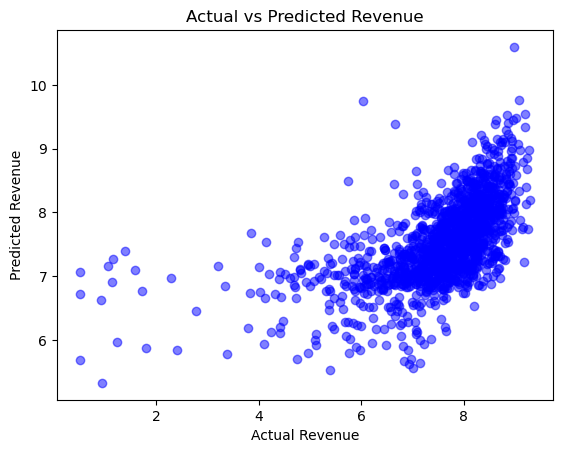

In [60]:
# Plotting actual revenue vs predicted revenue
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

Residual - Hover around zero

### Removing Topic Modelling

In [61]:
train.columns

Index(['runtime', 'budget_adj', 'revenue_adj', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Thriller', 'War', 'Western', 'original_language_en',
       'original_language_es', 'original_language_fr', 'original_language_hi',
       'original_language_it', 'original_language_ja', 'original_language_ko',
       'original_language_ru', 'original_language_ta', 'original_language_zh',
       'Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Walt Disney Pictures', 'Touchstone Pictures',
       'Relativity Media', 'Metro-Goldwyn-Mayer (MGM)', 'Other Prod',
       'quarter_1', 'quarter_2', 'quarter_3', 'series_num',
       'total_popular_cast', 'top_director', 'total_cast', 'Topic_Topic 1',
       'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Top

### Remove Topic Modelling GridSearchCV Lasso

In [62]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)
x_train.drop(['Topic_Topic 1',
       'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5',
       'Topic_Topic 6', 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9'], axis=1, inplace=True)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)
x_test.drop(['Topic_Topic 1',
       'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5',
       'Topic_Topic 6', 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9'], axis=1, inplace=True)

# Define y_test
y_test = test["revenue_adj"]

def abs_and_sum(arr):
    abs_values = [abs(x) for x in arr]
    sum_of_abs = sum(abs_values)
    return sum_of_abs

# Define the parameter grid for the grid search
param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100], 'fit_intercept':[True, False], 'max_iter':[1000,2000,5000]}

# Create a lasso regression model
model = linear_model.Lasso()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding MSE score
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Best Hyperparameters:", grid_search.best_params_)
print('Intercept:', best_model.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': best_model.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Best Hyperparameters: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 1000}
Intercept: 0.9550128679950642
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.834270              0.834270
40                              Other Prod     0.352259              0.352259
26                    original_language_ko     0.326874              0.326874
33  Twentieth Century Fox Film Corporation     0.286622              0.286622
31                      Universal Pictures     0.268154              0.268154
36                    Walt Disney Pictures     0.254397              0.254397
32                      Paramount Pictures     0.241930              0.241930
35                         New Line Cinema     0.231327              0.231327
34                       Columbia Pictures     0.216313              0.216313
22                    original_language_fr    -0.204789              0.204789
Train RMSE 0.728

### Remove Topic Modelling GridSearchCV Ridge

In [63]:
# Define x_train
x_train = train.drop(["revenue_adj"], axis=1)
x_train.drop(['Topic_Topic 1',
       'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5',
       'Topic_Topic 6', 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9'], axis=1, inplace=True)

# Define y_train
y_train = train["revenue_adj"]

# Define x_test
x_test = test.drop(["revenue_adj"], axis=1)
x_test.drop(['Topic_Topic 1',
       'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5',
       'Topic_Topic 6', 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9'], axis=1, inplace=True)

# Define y_test
y_test = test["revenue_adj"]

def abs_and_sum(arr):
    abs_values = [abs(x) for x in arr]
    sum_of_abs = sum(abs_values)
    return sum_of_abs

# Define the parameter grid for the grid search
param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100], 'fit_intercept':[True, False], 'max_iter':[1000,5000,10000]}

# Create a ridge regression model
model = linear_model.Ridge()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding MSE score
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Best Hyperparameters:", grid_search.best_params_)
print('Intercept:', best_model.intercept_)

# Create a DataFrame to store the coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': x_train.columns, 'Coefficient': best_model.coef_})

# Sort the DataFrame by absolute coefficient values in descending order
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top features
top10_features = coefficients_df.head(10)  # Change the number as needed
print("Top 10 Features")
print(top10_features)

print('Train RMSE', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('Test RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("Adjusted Train R-squared:", adj_rsquared(x_train, y_train, y_pred_train))
print("Adjusted Test R-squared:", adj_rsquared(x_test, y_test, y_pred_test))

Best Hyperparameters: {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000}
Intercept: 0.9736316424787113
Top 10 Features
                                   Feature  Coefficient  Absolute Coefficient
1                               budget_adj     0.831542              0.831542
40                              Other Prod     0.348457              0.348457
26                    original_language_ko     0.327686              0.327686
33  Twentieth Century Fox Film Corporation     0.297169              0.297169
31                      Universal Pictures     0.274052              0.274052
36                    Walt Disney Pictures     0.265075              0.265075
32                      Paramount Pictures     0.253400              0.253400
35                         New Line Cinema     0.245872              0.245872
34                       Columbia Pictures     0.230155              0.230155
22                    original_language_fr    -0.229164              0.229164
Train RMSE 0.727274